# Getting Started

_Author:_ [Giacomo Turri](https://github.com/g-turri)

In this example we show how `kooplearn` can be used to estimate the transfer operator of a simple **stochastic linear dynamical system** through the fitting of a *Principal Component Regression* (PCR) model implemented in {class}`kooplearn.linear.Ridge` and described in {footcite:t}`Kostic2022`. 
 
The system is of the form:

$$x_{t + 1} = A x_{t} + \xi_{t}$$

where the transfer operator is simply the transpose of $A$ and $\xi$ is Gaussian noise.

In [1]:
# Check if kooplearn is installed
import importlib

try:
  importlib.import_module('kooplearn')
except ImportError:
  module = 'kooplearn'
  %pip install -q {module}

## Data Generation
In `kooplearn`, we provide {class}`kooplearn.datasets.LinearModel` which can be used to sample data from a dynamical system defined by a matrix `A`. With this class, after having initialized the generator with matrix `A`, the variance of Gaussian noise (`noise`) and the random seed (`rng_seed`), we sample the dataset by setting the initial condition `X0` and the number of time steps `T` according to the sample sizes defined above.

In [2]:
import numpy as np
from kooplearn.datasets import LinearModel
from scipy.linalg import eigvals

seed = 42
np.random.seed(seed)
# Generate random matrix
A = np.random.randn(10, 10)
# Normalize to make the dynamical system stable
A = A / np.linalg.norm(A)
A_eigs = np.sort(eigvals(A))
#Initial point
X0 = np.random.randn(A.shape[0])
# Dataset generation and splitting
train_samples = int(1e5)
test_samples = int(1e3)
data = LinearModel(A, noise=0.1, rng_seed=seed).sample(
    X0=X0, T=train_samples + 100 + train_samples
)
train_set = data[: train_samples + 1]
test_set = data[: test_samples + 1]

## Principal Component Regression fitting (a.k.a. DMD)

We fit the PCR models by varying the size of the training set. For each model, to measure the goodness of the estimated operator, we compute (i) the Frobenius norm of the difference between the true and the estimated linear operator, $||A-\hat{A}||_F$, and (ii) the directed Hausdorff distance (DHD) between the set of true and predicted eigenvalues.

In [3]:
from kooplearn.linear_model import Ridge
from kooplearn.utils import directed_hausdorff_distance as DHD

train_stops = np.logspace(2, 5, 10).astype(int)
model = Ridge(n_components=len(A_eigs), reduced_rank=False, alpha=1e-6, eigen_solver='dense')

model_eigs = []
estimator_fitting_error = []
dhd_eigs = []
for i, stop in enumerate(train_stops):
    result = {}
    model = model.fit(train_set[:stop])
    model_eigs.append(model.eig()),
    estimator_fitting_error.append(np.linalg.norm(A.T - model.estimator_)),
    dhd_eigs.append(DHD(A_eigs, model.eig())),

In the left panel, we show how the Frobenius-norm error decreases as the number of training samples increases. The center panel shows that the eigenvalues associated with the learned operators also get better and better as the size of the training set increases. In fact, the right panel shows that the true and predicted eigenvalues are virtually the same (for $n=10^5$).

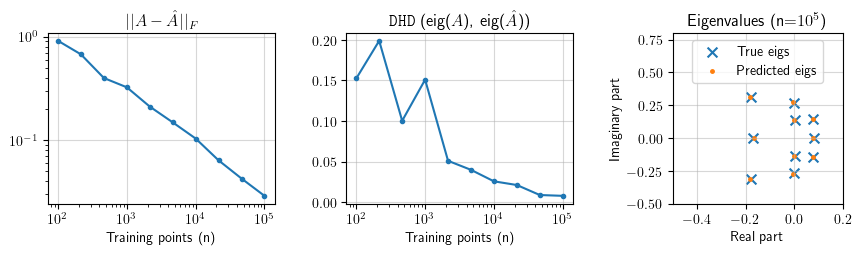

In [16]:
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
})

fig, axes = plt.subplots(ncols=3, figsize=(9,2.66))

ax = axes[0]
ax.grid(alpha=0.5)
ax.plot(train_stops, estimator_fitting_error, '.-')
ax.set_title("$|| A-\hat{A} ||_{F}$")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Training points (n)')

ax = axes[1]
ax.grid(alpha=0.5)
ax.plot(train_stops, dhd_eigs,'.-')
ax.set_title("$\mathtt{DHD}~$(eig($A$), eig($\hat{A}$))")
ax.set_xscale('log')
ax.set_xlabel('Training points (n)')

ax = axes[2]
pred_eigs = np.squeeze(model_eigs[-1])
ax.scatter(A_eigs.real, A_eigs.imag, label='True eigs', marker='x', s=50)
ax.scatter(pred_eigs.real, pred_eigs.imag, label='Predicted eigs', marker = '.', s=25)
# Plot unit circle
theta = np.linspace(0, 2*np.pi, 100)
ax.plot(np.cos(theta), np.sin(theta), linestyle='-', color='#999', lw=0.75)
ax.set_xlabel('Real part')
ax.set_ylabel('Imaginary part')
ax.set_title('Eigenvalues (n=$10^5$)')
ax.legend(loc='upper center', frameon=True)
ax.set_xlim((-0.5, 0.2))
ax.set_ylim((-0.5, 0.8))
ax.grid(alpha=0.5)
ax.set_box_aspect(1)

plt.tight_layout()
plt.show()